In [48]:
%reload_ext autoreload
%autoreload 2

from brian2 import *
from plotlib import *
from tqdm import tqdm

import experiment_12_thalamus as ex12
import pickle
import scipy.stats as stats


In [117]:
n_mod = 998
#n_mod = 100
start, end = 1000, 5000
dt, shift = 5, 5

In [118]:

def ex12_mapper(modulation):
    return ex12.run_experiment(n_mod=n_mod, thalamus_modulation=modulation)

p = Pool(5)
modulation = np.linspace(0, 1, 2)
data_array = p.map(ex12_mapper, modulation)
p.close()

In [119]:
len(data_array)

2

In [120]:
lzs = []
lzs = np.zeros((len(data_array), n_mod))

for idx, d in enumerate(data_array):
    sys.stdout.write("{}... ".format(idx))
    sys.stdout.flush()
    lzs[idx,:] = get_lz_comp(d, start, end, dt, shift)


0... 1... 

In [20]:
with open('experiment_data/exp12_lz.pickle', 'wb') as f:
    pickle.dump(lzs, f)

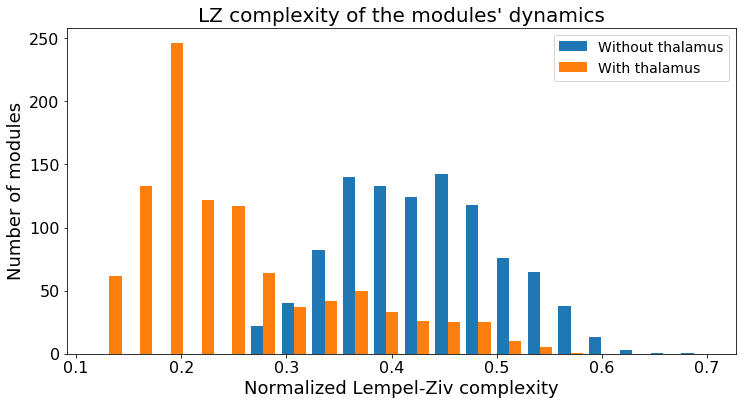

In [127]:

#_, axarr = plt.subplots(nrows=2, figsize=(12,6))
#plot_lz(lzs[0], start, end, dt, shift, ax=axarr[0], label='Thalamic modulation {:.2f}'.format(modulation[0]))
#plot_lz(lzs[-1], start, end, dt, shift, ax=axarr[-1], label='Thalamic modulation {:.2f}'.format(modulation[-1]))

_, ax = plt.subplots(figsize=(12,6))
n_steps = float(end - start) / shift
ax.hist([lzs[0] * np.log(n_steps) / n_steps,
         lzs[-1] * np.log(n_steps) / n_steps],
        #label=['Thalamic modulation {:.2f}'.format(modulation[0]),
        #       'Thalamic modulation {:.2f}'.format(modulation[-1])],
        label=['Without thalamus',
               'With thalamus'],
        bins=20
)


#n_steps = float(end - start) / shift
#for lz_comp in lzs:
#    lz_comp *= np.log(n_steps) / n_steps
#bins = np.linspace(0, 1, 30)
#ax.hist(lzs * np.log(n_steps) / n_steps,
#        bins,
#        label=['Thalamic modulation {:.2f}'.format(mod) for mod in modulation]
#)


#for lz_comp, mod in zip(lzs, modulation):
#    plot_lz(lz_comp, start, end, dt, shift, ax=ax, label='Thalamic modulation {:.2f}'.format(mod))
ax.set_xlabel('Normalized Lempel-Ziv complexity')
ax.set_ylabel('Number of modules')
ax.set_title('LZ complexity of the modules\' dynamics')
#for \n increasing levels of modulation from the thalamus')
plt.legend()
plt.savefig('figures/exp12_lz_thalamus_modulation.png')
plt.show()

In [64]:

for d in data_array:
X = data_array[1]['X']
print("{:,}".format(len(X)))

IndentationError: expected an indented block (<ipython-input-64-945d134733d3>, line 3)

In [ ]:
lzs[0].shape

In [ ]:
a = []
for i in tqdm(range(10)):
    x = 0
    for _ in np.arange(1e7):
        x += 1
    a.append((i, j))
print(a)

In [ ]:
data_array[0]

23,605,767 exc spikes, 13,621,716 inh spikes


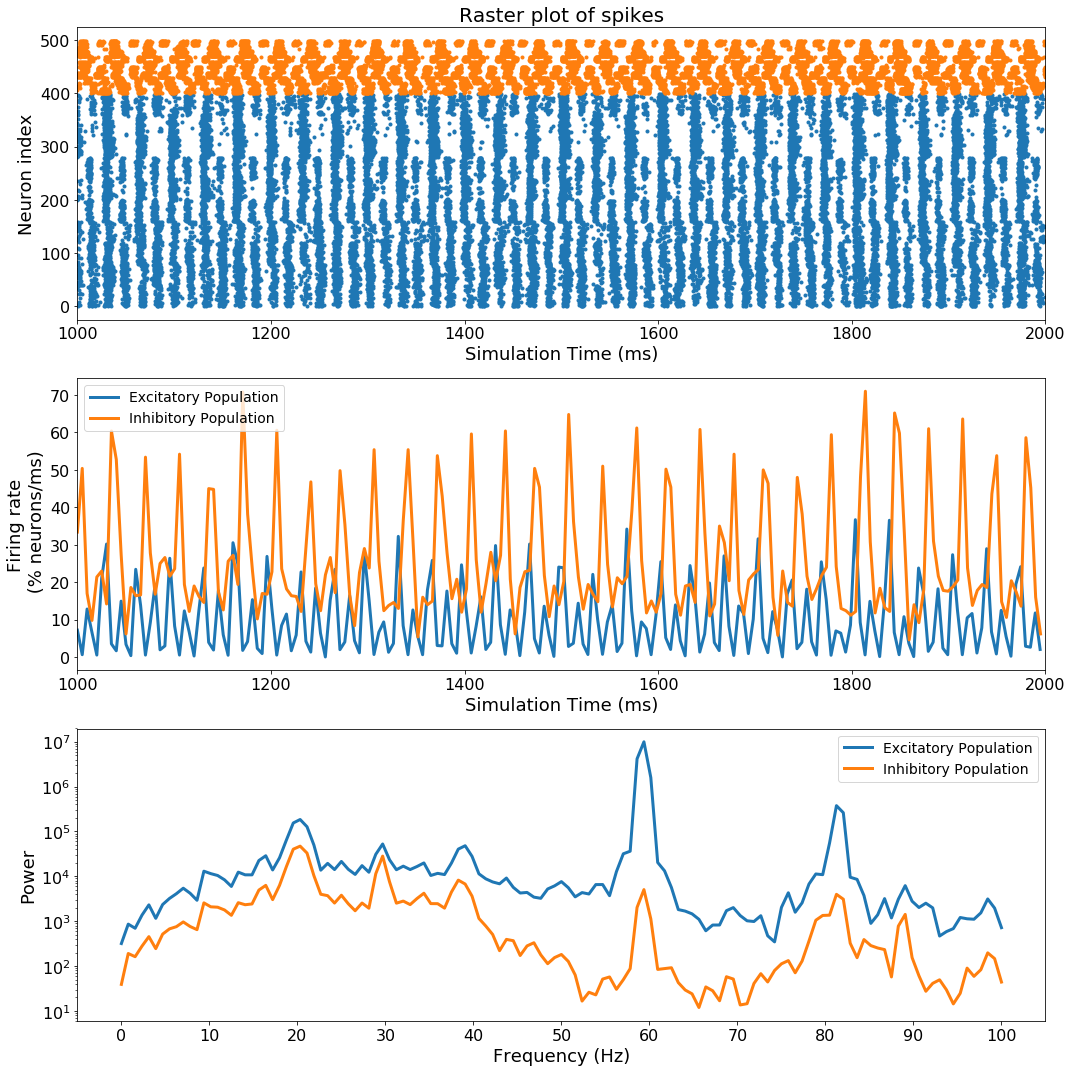

In [81]:
plot_stuff(data_array[-1], max_mod=10)